In [2]:
import sys
sys.path.insert(1, '../Src')
import numpy as np
import pandas as pd
import os
from utils.feature_engineering import *
from utils.preprocessing import *

PATH_DATASET = '../Dataset/'
#PATH_DATASET = '../Dataset/datah-m1-challange/'
PATH_RESULTS = '../Results/'

# loading dataset

In [32]:
df_sales  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','sales.pkl'))
df_items  = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','item.pkl'))
df_stores = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','store.pkl'))

df_submission_sample = pd.read_pickle(os.path.join(PATH_RESULTS,'dataset','submission_sample.pkl'))

N_submission = df_submission_sample.shape[0]
N_sales      = df_sales.shape[0]

df_sales = df_sales.merge(df_items,on=['I100'])
df_sales = df_sales.merge(df_stores,on=['S100'])
    
df_submission_sample = df_submission_sample.merge(df_items,on=['I100'])
df_submission_sample = df_submission_sample.merge(df_stores,on=['S100'])

df_sales.replace([np.inf, -np.inf, np.nan],0,inplace=True)
df_submission_sample.replace([np.inf, -np.inf, np.nan],0,inplace=True)

features_names = set(df_sales.columns)-set(['QTT','DATE','item_id','ID'])
print(features_names)

{'I103', 'I100', 'C100', 'S100', 'C101', 'S102', 'S103', 'I101', 'S101', 'I102'}


# Feature engineering

In [33]:
df_sales             = fe_dates(df_sales)
df_submission_sample = fe_dates(df_submission_sample)

In [34]:
df_sales             = string_to_categorical(df_sales).copy()
df_submission_sample = string_to_categorical(df_submission_sample).copy()

item_id object category
ID object category
item_id object category


In [35]:
for column in df_sales.columns:
    print(column,df_sales[column].nunique())


DATE 243
S100 31
I100 96
C100 21
C101 355
QTT 197
item_id 3827
I101 6
I102 3
I103 3
S101 2
S102 20
S103 11
year 5
month 12
day 31
day_of_week 1
day_of_year 243
is_year_start 1
is_quarter_start 2
is_month_start 2
is_month_end 2


In [36]:
print(df_sales.shape,df_submission_sample.shape)
df_auxiliar = pd.concat([df_sales,df_submission_sample])
df_auxiliar.replace([np.inf, -np.inf, np.nan],0,inplace=True)

for value in ["S100","S101", "S102","S103","I100","I101","I102","I103","C100","C101"]:        
    df_auxiliar[value] = df_auxiliar[value].astype(str).astype(int)


df_auxiliar = string_to_categorical(df_auxiliar).copy()

#df_auxiliar = pd.get_dummies(data=df_auxiliar, columns=["S100","S101", "S102","S103","I100","I101","I102","I103","C100","C101"])

#df_auxiliar = categorical_to_numeric(df_auxiliar)
df_sales, df_submission_sample = df_auxiliar[:N_sales], df_auxiliar[N_sales:]
print(df_sales.shape,df_submission_sample.shape)

(2749369, 22) (69121, 23)
item_id object category
(2749369, 23) (69121, 23)


In [37]:
df_submission_sample['DATE'].min(),df_submission_sample['DATE'].max()

(Timestamp('2021-10-03 00:00:00'), Timestamp('2021-11-21 00:00:00'))

In [38]:
#df_sales2 = df_sales[df_sales['QTT']<=15].copy()

In [39]:
#df_submission_sample = df_submission_sample[df_submission_sample['S100']==0]

In [40]:
features_names = set(df_sales.columns)-set(['QTT','DATE','item_id','ID'])
print(len(features_names))
#{'I103', 'is_year_start', 'I101', 'C100', 'day', 'S100', 'year', 'month', 'is_month_start', 'day_of_week', 'I102', 
#'I100', 'S101', 'day_of_year', 'is_quarter_start', 'C101', 'S103', 'S102', 'is_month_end'}

19


In [51]:
df_submission_sample.head(2)


,DATE,S100,I100,C100,C101,QTT,item_id,I101,I102,I103,...,year,month,day,day_of_week,day_of_year,is_year_start,is_quarter_start,is_month_start,is_month_end,ID
0,2021-10-03,0,1,12,140,-1,1_12_140,2,1,1,...,2021,10,3,6,276,False,False,False,False,2021-10-03_0_1_12_140
1,2021-10-03,0,1,12,164,-1,1_12_164,2,1,1,...,2021,10,3,6,276,False,False,False,False,2021-10-03_0_1_12_164


In [228]:
hyper_params ={      
  'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    'feature_fraction': 0.6,
    'max_bin': 100,
    #'n_estimators': …,   
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 12
   }    

In [229]:
import lightgbm as lgb

hyper_params = {
    'device':'gpu',
    'is_unbalance':True,
    'is_enable_sparse':True,
    'task': 'train',
    'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric':  ['rmse'],
    'verbose': 0,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    "max_depth": 10,
    "num_leaves": 64,  
    "max_bin": 128,
    "num_iterations": 800
}


hyper_params ={      
  'boosting_type': 'gbdt',
   'objective': 'tweedie',
   'tweedie_variance_power': 1.1,
    'metric': 'rmse',
    'subsample': 0.6,
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'num_leaves': 2**11-1,
    'min_data_in_leaf': 2**12-1,
    'feature_fraction': 0.6,
    'max_bin': 100,
    #'n_estimators': …,   
    'boost_from_average': False,
    'verbose': -1,
    'num_threads': 12
   }    


In [249]:
#unique_stores

In [252]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

model_version = 'model_v1'
unique_stores = sorted(df_submission_sample['S100'].unique())

predictions_store = {}

for store in unique_stores:
    print('*'*10,store,'*'*10)
    print('Analyzing store :',store)
    
    df_sales2             = df_sales[df_sales['S100']==store]
    df_submission_sample2 = df_submission_sample[df_submission_sample['S100']==store]
    
    X_train      = df_sales2[(df_sales2['DATE'] >= '2017-01-01') & (df_sales2['DATE'] < '2021-05-01')].copy()
    X_validation = df_sales2[(df_sales2['DATE'] >= '2021-05-01') & (df_sales2['DATE'] < '2021-08-01')].copy()
    X_test       = df_sales2[(df_sales2['DATE'] >= '2021-08-01') & (df_sales2['DATE'] < '2021-10-03')].copy() 
    
    y_train = X_train['QTT']
    X_train = X_train[features_names]
    
    y_validation = X_validation['QTT']
    X_validation = X_validation[features_names]
    
    y_test = X_test['QTT']
    X_test = X_test[features_names]

    y_submission = df_submission_sample2['QTT']
    X_submission = df_submission_sample2[features_names]

    
    print('X_train      ',X_train.shape)
    print('y_validation ',y_validation.shape)
    print('X_test       ',X_test.shape)
    print('X_submission ',X_submission.shape)
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_validation, y_validation)

    gbm2 = lgb.train(hyper_params, lgb_train, 3000, valid_sets=[lgb_train, lgb_valid],early_stopping_rounds=50, verbose_eval=50)





    print('make predictions...')
    X_train_pred      = gbm2.predict(X_train)#, num_iteration=gbm.best_iteration_)
    X_validation_pred = gbm2.predict(X_validation)#, num_iteration=gbm.best_iteration_)
    X_test_pred       = gbm2.predict(X_test)#, num_iteration=gbm.best_iteration_)

    X_submission_pred = gbm2.predict(X_submission)#, num_iteration=gbm.best_iteration_)

    
    X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    X_test_pred = np.maximum(X_test_pred, 0)
    X_submission_pred = np.maximum(X_submission_pred, 0)

    df_train_rmse = mean_squared_error(y_train,X_train_pred, squared=False)
    df_val_rmse   = mean_squared_error(y_validation,X_validation_pred, squared=False)
    df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

    print('Final score mean_squared_error')
    print('Score train:',df_train_rmse)
    print('Score val  :',df_val_rmse)
    print('Score test :',df_test_rmse)
    
    
    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_'+str(store)+'.txt')
    print('saving model..',model_name)
    gbm2.save_model(model_name, num_iteration=gbm2.best_iteration)
    
    predictions_store[store] = X_submission_pred



********** 0 **********
Analyzing store : 0
X_train       (91205, 19)
y_validation  (5048,)
X_test        (3597, 19)
X_submission  (2822, 19)
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 2.56758	valid_1's rmse: 2.63407
[100]	training's rmse: 2.43104	valid_1's rmse: 2.49977
[150]	training's rmse: 2.371	valid_1's rmse: 2.43979
[200]	training's rmse: 2.33496	valid_1's rmse: 2.40849
[250]	training's rmse: 2.3099	valid_1's rmse: 2.39009
[300]	training's rmse: 2.28823	valid_1's rmse: 2.37392
[350]	training's rmse: 2.27083	valid_1's rmse: 2.36229
[400]	training's rmse: 2.25701	valid_1's rmse: 2.35338
[450]	training's rmse: 2.2455	valid_1's rmse: 2.34466
[500]	training's rmse: 2.23531	valid_1's rmse: 2.33809
[550]	training's rmse: 2.22518	valid_1's rmse: 2.32981
[600]	training's rmse: 2.21599	valid_1's rmse: 2.32395
[650]	training's rmse: 2.20578	valid_1's rmse: 2.32085
[700]	training's rmse: 2.19733	valid_1's rmse: 2.3158
[750]	training's rmse: 2.18993	va

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.05418	valid_1's rmse: 1.5106
[100]	training's rmse: 1.97605	valid_1's rmse: 1.4511
[150]	training's rmse: 1.9436	valid_1's rmse: 1.4344
[200]	training's rmse: 1.92284	valid_1's rmse: 1.42587
[250]	training's rmse: 1.90583	valid_1's rmse: 1.41941
[300]	training's rmse: 1.89012	valid_1's rmse: 1.41448
[350]	training's rmse: 1.87694	valid_1's rmse: 1.41155
[400]	training's rmse: 1.86507	valid_1's rmse: 1.4096
[450]	training's rmse: 1.85569	valid_1's rmse: 1.40869
[500]	training's rmse: 1.84658	valid_1's rmse: 1.40739
[550]	training's rmse: 1.8386	valid_1's rmse: 1.40631
[600]	training's rmse: 1.83141	valid_1's rmse: 1.40595
[650]	training's rmse: 1.82549	valid_1's rmse: 1.40595
Early stopping, best iteration is:
[603]	training's rmse: 1.83109	valid_1's rmse: 1.40584
make predictions...
Final score mean_squared_error
Score train: 1.831093150478635
Score val  : 1.4058445754188327
Score test : 1.565100922048357
saving model.. ../Results/lightgbm/model_v1/model_1.txt
*

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.25862	valid_1's rmse: 3.11981
[100]	training's rmse: 2.16552	valid_1's rmse: 2.98383
[150]	training's rmse: 2.1276	valid_1's rmse: 2.92191
[200]	training's rmse: 2.10578	valid_1's rmse: 2.88263
[250]	training's rmse: 2.08743	valid_1's rmse: 2.85128
[300]	training's rmse: 2.07223	valid_1's rmse: 2.82893
[350]	training's rmse: 2.0596	valid_1's rmse: 2.817
[400]	training's rmse: 2.04798	valid_1's rmse: 2.81428
[450]	training's rmse: 2.03824	valid_1's rmse: 2.80827
[500]	training's rmse: 2.02964	valid_1's rmse: 2.80563
[550]	training's rmse: 2.02139	valid_1's rmse: 2.79936
[600]	training's rmse: 2.01306	valid_1's rmse: 2.79851
Early stopping, best iteration is:
[574]	training's rmse: 2.01754	valid_1's rmse: 2.79491
make predictions...
Final score mean_squared_error
Score train: 2.017537950680969
Score val  : 2.7949093370687783
Score test : 2.043136179286473
saving model.. ../Results/lightgbm/model_v1/model_2.txt
********** 3 **********
Analyzing store : 3
X_train   

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 4.28988	valid_1's rmse: 3.52955
[100]	training's rmse: 4.14702	valid_1's rmse: 3.38267
[150]	training's rmse: 4.10719	valid_1's rmse: 3.34741
[200]	training's rmse: 4.08748	valid_1's rmse: 3.33095
[250]	training's rmse: 4.07349	valid_1's rmse: 3.31969
[300]	training's rmse: 4.06142	valid_1's rmse: 3.31144
[350]	training's rmse: 4.05136	valid_1's rmse: 3.3031
[400]	training's rmse: 4.04224	valid_1's rmse: 3.2959
[450]	training's rmse: 4.03408	valid_1's rmse: 3.28902
[500]	training's rmse: 4.02718	valid_1's rmse: 3.28262
[550]	training's rmse: 4.02005	valid_1's rmse: 3.27659
[600]	training's rmse: 4.01404	valid_1's rmse: 3.27119
[650]	training's rmse: 4.00832	valid_1's rmse: 3.26745
[700]	training's rmse: 4.00266	valid_1's rmse: 3.26294
[750]	training's rmse: 3.99732	valid_1's rmse: 3.25941
[800]	training's rmse: 3.99284	valid_1's rmse: 3.25551
[850]	training's rmse: 3.98812	valid_1's rmse: 3.25083
[900]	training's rmse: 3.98372	valid_1's rmse: 3.24719
[950]	trainin

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.47962	valid_1's rmse: 2.32491
[100]	training's rmse: 2.34801	valid_1's rmse: 2.20167
[150]	training's rmse: 2.28927	valid_1's rmse: 2.15409
[200]	training's rmse: 2.25676	valid_1's rmse: 2.13226
[250]	training's rmse: 2.23072	valid_1's rmse: 2.1086
[300]	training's rmse: 2.20886	valid_1's rmse: 2.09053
[350]	training's rmse: 2.19141	valid_1's rmse: 2.07529
[400]	training's rmse: 2.17579	valid_1's rmse: 2.06366
[450]	training's rmse: 2.16267	valid_1's rmse: 2.05214
[500]	training's rmse: 2.15162	valid_1's rmse: 2.04478
[550]	training's rmse: 2.14063	valid_1's rmse: 2.03552
[600]	training's rmse: 2.13103	valid_1's rmse: 2.02874
[650]	training's rmse: 2.12125	valid_1's rmse: 2.01882
[700]	training's rmse: 2.1127	valid_1's rmse: 2.01265
[750]	training's rmse: 2.10499	valid_1's rmse: 2.00583
[800]	training's rmse: 2.09769	valid_1's rmse: 2.00003
[850]	training's rmse: 2.09062	valid_1's rmse: 1.99573
[900]	training's rmse: 2.08332	valid_1's rmse: 1.98847
[950]	trainin

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.76782	valid_1's rmse: 3.0511
[100]	training's rmse: 2.63136	valid_1's rmse: 2.88332
[150]	training's rmse: 2.57012	valid_1's rmse: 2.80239
[200]	training's rmse: 2.53265	valid_1's rmse: 2.7574
[250]	training's rmse: 2.50642	valid_1's rmse: 2.72915
[300]	training's rmse: 2.48469	valid_1's rmse: 2.70479
[350]	training's rmse: 2.467	valid_1's rmse: 2.68823
[400]	training's rmse: 2.45024	valid_1's rmse: 2.67685
[450]	training's rmse: 2.43568	valid_1's rmse: 2.66318
[500]	training's rmse: 2.42404	valid_1's rmse: 2.65134
[550]	training's rmse: 2.41267	valid_1's rmse: 2.64176
[600]	training's rmse: 2.40245	valid_1's rmse: 2.6328
[650]	training's rmse: 2.39343	valid_1's rmse: 2.63025
[700]	training's rmse: 2.3845	valid_1's rmse: 2.62333
[750]	training's rmse: 2.37628	valid_1's rmse: 2.61675
[800]	training's rmse: 2.36888	valid_1's rmse: 2.61402
[850]	training's rmse: 2.36202	valid_1's rmse: 2.60977
[900]	training's rmse: 2.35598	valid_1's rmse: 2.60645
[950]	training's 

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 3.18127	valid_1's rmse: 3.60863
[100]	training's rmse: 2.97879	valid_1's rmse: 3.36531
[150]	training's rmse: 2.88872	valid_1's rmse: 3.25743
[200]	training's rmse: 2.83447	valid_1's rmse: 3.19423
[250]	training's rmse: 2.79312	valid_1's rmse: 3.17476
[300]	training's rmse: 2.75875	valid_1's rmse: 3.15836
[350]	training's rmse: 2.7303	valid_1's rmse: 3.14558
[400]	training's rmse: 2.70833	valid_1's rmse: 3.14229
[450]	training's rmse: 2.68899	valid_1's rmse: 3.13465
[500]	training's rmse: 2.67225	valid_1's rmse: 3.13517
Early stopping, best iteration is:
[463]	training's rmse: 2.68427	valid_1's rmse: 3.13296
make predictions...
Final score mean_squared_error
Score train: 2.684273910901341
Score val  : 3.1329557956547056
Score test : 3.3985630790389534
saving model.. ../Results/lightgbm/model_v1/model_7.txt
********** 8 **********
Analyzing store : 8
X_train       (78970, 19)
y_validation  (4549,)
X_test        (3306, 19)
X_submission  (2434, 19)
Training until val

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.09465	valid_1's rmse: 2.99178
[100]	training's rmse: 1.98844	valid_1's rmse: 2.85093
[150]	training's rmse: 1.94925	valid_1's rmse: 2.79057
[200]	training's rmse: 1.92797	valid_1's rmse: 2.76171
[250]	training's rmse: 1.91276	valid_1's rmse: 2.74846
[300]	training's rmse: 1.90082	valid_1's rmse: 2.74019
[350]	training's rmse: 1.89057	valid_1's rmse: 2.73641
[400]	training's rmse: 1.88235	valid_1's rmse: 2.73058
[450]	training's rmse: 1.87474	valid_1's rmse: 2.7274
[500]	training's rmse: 1.86847	valid_1's rmse: 2.7255
[550]	training's rmse: 1.86239	valid_1's rmse: 2.72618
Early stopping, best iteration is:
[510]	training's rmse: 1.86731	valid_1's rmse: 2.72497
make predictions...
Final score mean_squared_error
Score train: 1.867306069345089
Score val  : 2.7249722581334024
Score test : 2.0986422103777005
saving model.. ../Results/lightgbm/model_v1/model_8.txt
********** 9 **********
Analyzing store : 9
X_train       (82191, 19)
y_validation  (4537,)
X_test        

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.2374	valid_1's rmse: 1.95819
[100]	training's rmse: 2.13923	valid_1's rmse: 1.8622
[150]	training's rmse: 2.10014	valid_1's rmse: 1.82902
[200]	training's rmse: 2.07253	valid_1's rmse: 1.80927
[250]	training's rmse: 2.05096	valid_1's rmse: 1.79269
[300]	training's rmse: 2.03193	valid_1's rmse: 1.7763
[350]	training's rmse: 2.01673	valid_1's rmse: 1.7644
[400]	training's rmse: 2.00304	valid_1's rmse: 1.75349
[450]	training's rmse: 1.99144	valid_1's rmse: 1.74366
[500]	training's rmse: 1.98025	valid_1's rmse: 1.73421
[550]	training's rmse: 1.97161	valid_1's rmse: 1.72742
[600]	training's rmse: 1.96213	valid_1's rmse: 1.72009
[650]	training's rmse: 1.9539	valid_1's rmse: 1.71294
[700]	training's rmse: 1.94528	valid_1's rmse: 1.70554
[750]	training's rmse: 1.93687	valid_1's rmse: 1.69915
[800]	training's rmse: 1.92976	valid_1's rmse: 1.69299
[850]	training's rmse: 1.92323	valid_1's rmse: 1.68959
[900]	training's rmse: 1.91594	valid_1's rmse: 1.68279
[950]	training's

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 3.04009	valid_1's rmse: 3.31956
[100]	training's rmse: 2.8918	valid_1's rmse: 3.1451
[150]	training's rmse: 2.83051	valid_1's rmse: 3.07011
[200]	training's rmse: 2.79176	valid_1's rmse: 3.03173
[250]	training's rmse: 2.76047	valid_1's rmse: 3.01552
[300]	training's rmse: 2.73495	valid_1's rmse: 3.00174
[350]	training's rmse: 2.71257	valid_1's rmse: 2.99252
[400]	training's rmse: 2.69337	valid_1's rmse: 2.98606
[450]	training's rmse: 2.67442	valid_1's rmse: 2.97763
[500]	training's rmse: 2.65786	valid_1's rmse: 2.97997
Early stopping, best iteration is:
[471]	training's rmse: 2.66709	valid_1's rmse: 2.977
make predictions...
Final score mean_squared_error
Score train: 2.6670933701453077
Score val  : 2.9769952079654893
Score test : 2.7537473223653883
saving model.. ../Results/lightgbm/model_v1/model_10.txt
********** 12 **********
Analyzing store : 12
X_train       (92915, 19)
y_validation  (6206,)
X_test        (3969, 19)
X_submission  (2804, 19)
Training until va

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.52547	valid_1's rmse: 2.9937
[100]	training's rmse: 2.39873	valid_1's rmse: 2.83203
[150]	training's rmse: 2.33771	valid_1's rmse: 2.7503
[200]	training's rmse: 2.29673	valid_1's rmse: 2.6971
[250]	training's rmse: 2.26606	valid_1's rmse: 2.66607
[300]	training's rmse: 2.23938	valid_1's rmse: 2.64161
[350]	training's rmse: 2.21643	valid_1's rmse: 2.62621
[400]	training's rmse: 2.19513	valid_1's rmse: 2.61298
[450]	training's rmse: 2.17846	valid_1's rmse: 2.60424
[500]	training's rmse: 2.1636	valid_1's rmse: 2.60192
[550]	training's rmse: 2.15024	valid_1's rmse: 2.59743
[600]	training's rmse: 2.13853	valid_1's rmse: 2.59421
[650]	training's rmse: 2.12832	valid_1's rmse: 2.59183
[700]	training's rmse: 2.11807	valid_1's rmse: 2.59013
[750]	training's rmse: 2.10886	valid_1's rmse: 2.58807
Early stopping, best iteration is:
[723]	training's rmse: 2.11326	valid_1's rmse: 2.58697
make predictions...
Final score mean_squared_error
Score train: 2.113262069395885
Score va

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.87324	valid_1's rmse: 2.98171
[100]	training's rmse: 2.70532	valid_1's rmse: 2.79008
[150]	training's rmse: 2.62781	valid_1's rmse: 2.69755
[200]	training's rmse: 2.58186	valid_1's rmse: 2.64155
[250]	training's rmse: 2.54357	valid_1's rmse: 2.59777
[300]	training's rmse: 2.5157	valid_1's rmse: 2.56309
[350]	training's rmse: 2.4955	valid_1's rmse: 2.54735
[400]	training's rmse: 2.47817	valid_1's rmse: 2.53941
[450]	training's rmse: 2.46466	valid_1's rmse: 2.53199
[500]	training's rmse: 2.45265	valid_1's rmse: 2.52407
[550]	training's rmse: 2.44185	valid_1's rmse: 2.52294
[600]	training's rmse: 2.43114	valid_1's rmse: 2.51227
[650]	training's rmse: 2.42183	valid_1's rmse: 2.50873
[700]	training's rmse: 2.413	valid_1's rmse: 2.50269
[750]	training's rmse: 2.40496	valid_1's rmse: 2.50002
Early stopping, best iteration is:
[732]	training's rmse: 2.40734	valid_1's rmse: 2.49884
make predictions...
Final score mean_squared_error
Score train: 2.4073357772336403
Score v

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.29214	valid_1's rmse: 1.83371
[100]	training's rmse: 2.18488	valid_1's rmse: 1.76387
[150]	training's rmse: 2.14042	valid_1's rmse: 1.74759
[200]	training's rmse: 2.11512	valid_1's rmse: 1.73797
[250]	training's rmse: 2.09594	valid_1's rmse: 1.73074
[300]	training's rmse: 2.07997	valid_1's rmse: 1.72312
[350]	training's rmse: 2.0676	valid_1's rmse: 1.71736
[400]	training's rmse: 2.05612	valid_1's rmse: 1.71094
[450]	training's rmse: 2.04624	valid_1's rmse: 1.70458
[500]	training's rmse: 2.03759	valid_1's rmse: 1.69926
[550]	training's rmse: 2.02897	valid_1's rmse: 1.69553
[600]	training's rmse: 2.02148	valid_1's rmse: 1.69074
[650]	training's rmse: 2.01466	valid_1's rmse: 1.68857
[700]	training's rmse: 2.00801	valid_1's rmse: 1.68496
[750]	training's rmse: 2.00179	valid_1's rmse: 1.68216
[800]	training's rmse: 1.99713	valid_1's rmse: 1.68004
[850]	training's rmse: 1.99238	valid_1's rmse: 1.6783
[900]	training's rmse: 1.988	valid_1's rmse: 1.6756
[950]	training's

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.39061	valid_1's rmse: 2.03671
[100]	training's rmse: 2.26642	valid_1's rmse: 1.93962
[150]	training's rmse: 2.21749	valid_1's rmse: 1.90593
[200]	training's rmse: 2.18811	valid_1's rmse: 1.89195
[250]	training's rmse: 2.16629	valid_1's rmse: 1.8835
[300]	training's rmse: 2.14823	valid_1's rmse: 1.88011
[350]	training's rmse: 2.13546	valid_1's rmse: 1.87724
[400]	training's rmse: 2.12404	valid_1's rmse: 1.8769
[450]	training's rmse: 2.11393	valid_1's rmse: 1.87519
[500]	training's rmse: 2.10517	valid_1's rmse: 1.8752
Early stopping, best iteration is:
[475]	training's rmse: 2.10925	valid_1's rmse: 1.8743
make predictions...
Final score mean_squared_error
Score train: 2.1092502463010967
Score val  : 1.8742964164326663
Score test : 1.8755202148199521
saving model.. ../Results/lightgbm/model_v1/model_15.txt
********** 16 **********
Analyzing store : 16
X_train       (85251, 19)
y_validation  (4735,)
X_test        (3041, 19)
X_submission  (2448, 19)
Training until va

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 3.37069	valid_1's rmse: 3.35601
[100]	training's rmse: 3.15855	valid_1's rmse: 3.13429
[150]	training's rmse: 3.05535	valid_1's rmse: 3.04718
[200]	training's rmse: 2.98703	valid_1's rmse: 3.00498
[250]	training's rmse: 2.92886	valid_1's rmse: 2.97693
[300]	training's rmse: 2.88296	valid_1's rmse: 2.94706
[350]	training's rmse: 2.84488	valid_1's rmse: 2.93526
[400]	training's rmse: 2.81367	valid_1's rmse: 2.9243
[450]	training's rmse: 2.78679	valid_1's rmse: 2.91501
[500]	training's rmse: 2.76385	valid_1's rmse: 2.9149
[550]	training's rmse: 2.74201	valid_1's rmse: 2.90369
[600]	training's rmse: 2.72188	valid_1's rmse: 2.89978
[650]	training's rmse: 2.70597	valid_1's rmse: 2.89446
[700]	training's rmse: 2.68792	valid_1's rmse: 2.89027
[750]	training's rmse: 2.67277	valid_1's rmse: 2.88347
[800]	training's rmse: 2.65849	valid_1's rmse: 2.879
[850]	training's rmse: 2.64666	valid_1's rmse: 2.87751
[900]	training's rmse: 2.63525	valid_1's rmse: 2.87329
[950]	training'

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 3.14654	valid_1's rmse: 3.26516
[100]	training's rmse: 3.00507	valid_1's rmse: 3.09686
[150]	training's rmse: 2.9459	valid_1's rmse: 3.02741
[200]	training's rmse: 2.91162	valid_1's rmse: 2.99354
[250]	training's rmse: 2.88675	valid_1's rmse: 2.96915
[300]	training's rmse: 2.86664	valid_1's rmse: 2.94641
[350]	training's rmse: 2.8483	valid_1's rmse: 2.92604
[400]	training's rmse: 2.83208	valid_1's rmse: 2.90862
[450]	training's rmse: 2.81741	valid_1's rmse: 2.89396
[500]	training's rmse: 2.80482	valid_1's rmse: 2.88614
[550]	training's rmse: 2.79129	valid_1's rmse: 2.87447
[600]	training's rmse: 2.78088	valid_1's rmse: 2.86569
[650]	training's rmse: 2.77072	valid_1's rmse: 2.85795
[700]	training's rmse: 2.75924	valid_1's rmse: 2.84731
[750]	training's rmse: 2.74899	valid_1's rmse: 2.84027
[800]	training's rmse: 2.74045	valid_1's rmse: 2.83689
[850]	training's rmse: 2.73233	valid_1's rmse: 2.83135
[900]	training's rmse: 2.72485	valid_1's rmse: 2.82698
[950]	trainin

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.85713	valid_1's rmse: 2.20653
[100]	training's rmse: 2.74197	valid_1's rmse: 2.12233
[150]	training's rmse: 2.69641	valid_1's rmse: 2.09658
[200]	training's rmse: 2.66753	valid_1's rmse: 2.08414
[250]	training's rmse: 2.64423	valid_1's rmse: 2.0737
[300]	training's rmse: 2.62591	valid_1's rmse: 2.0667
[350]	training's rmse: 2.61121	valid_1's rmse: 2.05983
[400]	training's rmse: 2.59808	valid_1's rmse: 2.05565
[450]	training's rmse: 2.58651	valid_1's rmse: 2.05064
[500]	training's rmse: 2.57663	valid_1's rmse: 2.04761
[550]	training's rmse: 2.56637	valid_1's rmse: 2.04471
[600]	training's rmse: 2.55671	valid_1's rmse: 2.0417
[650]	training's rmse: 2.54765	valid_1's rmse: 2.03815
[700]	training's rmse: 2.5392	valid_1's rmse: 2.03402
[750]	training's rmse: 2.53036	valid_1's rmse: 2.03234
[800]	training's rmse: 2.52268	valid_1's rmse: 2.0308
[850]	training's rmse: 2.51598	valid_1's rmse: 2.02877
[900]	training's rmse: 2.50887	valid_1's rmse: 2.02752
[950]	training's

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.18811	valid_1's rmse: 2.13766
[100]	training's rmse: 2.10475	valid_1's rmse: 2.0442
[150]	training's rmse: 2.06729	valid_1's rmse: 2.00182
[200]	training's rmse: 2.04023	valid_1's rmse: 1.97863
[250]	training's rmse: 2.01891	valid_1's rmse: 1.9632
[300]	training's rmse: 1.99978	valid_1's rmse: 1.9486
[350]	training's rmse: 1.98418	valid_1's rmse: 1.93894
[400]	training's rmse: 1.97088	valid_1's rmse: 1.92745
[450]	training's rmse: 1.95901	valid_1's rmse: 1.91872
[500]	training's rmse: 1.94832	valid_1's rmse: 1.91217
[550]	training's rmse: 1.93814	valid_1's rmse: 1.90685
[600]	training's rmse: 1.92822	valid_1's rmse: 1.89953
[650]	training's rmse: 1.92001	valid_1's rmse: 1.89494
[700]	training's rmse: 1.91175	valid_1's rmse: 1.89032
[750]	training's rmse: 1.90348	valid_1's rmse: 1.8847
[800]	training's rmse: 1.89715	valid_1's rmse: 1.88107
[850]	training's rmse: 1.89146	valid_1's rmse: 1.88029
[900]	training's rmse: 1.88617	valid_1's rmse: 1.87753
[950]	training'

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.84805	valid_1's rmse: 2.98989
[100]	training's rmse: 2.72973	valid_1's rmse: 2.84353
[150]	training's rmse: 2.68181	valid_1's rmse: 2.78543
[200]	training's rmse: 2.65356	valid_1's rmse: 2.75731
[250]	training's rmse: 2.63296	valid_1's rmse: 2.73886
[300]	training's rmse: 2.61543	valid_1's rmse: 2.72563
[350]	training's rmse: 2.6003	valid_1's rmse: 2.71615
[400]	training's rmse: 2.58776	valid_1's rmse: 2.70674
[450]	training's rmse: 2.57667	valid_1's rmse: 2.69986
[500]	training's rmse: 2.56747	valid_1's rmse: 2.6953
[550]	training's rmse: 2.55799	valid_1's rmse: 2.69058
[600]	training's rmse: 2.54937	valid_1's rmse: 2.6829
[650]	training's rmse: 2.54196	valid_1's rmse: 2.68136
[700]	training's rmse: 2.53425	valid_1's rmse: 2.67773
[750]	training's rmse: 2.527	valid_1's rmse: 2.6741
[800]	training's rmse: 2.52055	valid_1's rmse: 2.67134
[850]	training's rmse: 2.51411	valid_1's rmse: 2.66871
[900]	training's rmse: 2.50882	valid_1's rmse: 2.66591
[950]	training's 

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is d

Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 3.08002	valid_1's rmse: 2.68113
[100]	training's rmse: 2.93127	valid_1's rmse: 2.53974
[150]	training's rmse: 2.86462	valid_1's rmse: 2.48943
[200]	training's rmse: 2.82456	valid_1's rmse: 2.4713
[250]	training's rmse: 2.79221	valid_1's rmse: 2.45641
[300]	training's rmse: 2.76462	valid_1's rmse: 2.44535
[350]	training's rmse: 2.73995	valid_1's rmse: 2.43339
[400]	training's rmse: 2.7181	valid_1's rmse: 2.41946
[450]	training's rmse: 2.69909	valid_1's rmse: 2.40905
[500]	training's rmse: 2.68331	valid_1's rmse: 2.40331
[550]	training's rmse: 2.66702	valid_1's rmse: 2.4001
[600]	training's rmse: 2.65425	valid_1's rmse: 2.39449
[650]	training's rmse: 2.64106	valid_1's rmse: 2.3923
[700]	training's rmse: 2.6289	valid_1's rmse: 2.3897
[750]	training's rmse: 2.6177	valid_1's rmse: 2.38558
[800]	training's rmse: 2.60753	valid_1's rmse: 2.38336
[850]	training's rmse: 2.59854	valid_1's rmse: 2.38065
[900]	traini

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.38574	valid_1's rmse: 1.87834
[100]	training's rmse: 2.26935	valid_1's rmse: 1.82143
[150]	training's rmse: 2.21469	valid_1's rmse: 1.79669
[200]	training's rmse: 2.17971	valid_1's rmse: 1.77728
[250]	training's rmse: 2.15569	valid_1's rmse: 1.76106
[300]	training's rmse: 2.13594	valid_1's rmse: 1.7474
[350]	training's rmse: 2.12088	valid_1's rmse: 1.7356
[400]	training's rmse: 2.10969	valid_1's rmse: 1.72685
[450]	training's rmse: 2.09994	valid_1's rmse: 1.71978
[500]	training's rmse: 2.0914	valid_1's rmse: 1.71378
[550]	training's rmse: 2.08259	valid_1's rmse: 1.70762
[600]	training's rmse: 2.075	valid_1's rmse: 1.70248
[650]	training's rmse: 2.06802	valid_1's rmse: 1.6984
[700]	training's rmse: 2.06134	valid_1's rmse: 1.69473
[750]	training's rmse: 2.05541	valid_1's rmse: 1.69161
[800]	training's rmse: 2.0501	valid_1's rmse: 1.68898
[850]	training's rmse: 2.0454	valid_1's rmse: 1.68625
[900]	training's rmse: 2.04141	valid_1's rmse: 1.68372
[950]	training's rm

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 1.99026	valid_1's rmse: 2.02662
[100]	training's rmse: 1.90651	valid_1's rmse: 1.95438
[150]	training's rmse: 1.87614	valid_1's rmse: 1.92905
[200]	training's rmse: 1.85857	valid_1's rmse: 1.91559
[250]	training's rmse: 1.84515	valid_1's rmse: 1.90703
[300]	training's rmse: 1.83438	valid_1's rmse: 1.89974
[350]	training's rmse: 1.82607	valid_1's rmse: 1.89438
[400]	training's rmse: 1.81814	valid_1's rmse: 1.89108
[450]	training's rmse: 1.81163	valid_1's rmse: 1.88722
[500]	training's rmse: 1.80585	valid_1's rmse: 1.88406
[550]	training's rmse: 1.80038	valid_1's rmse: 1.88164
[600]	training's rmse: 1.79524	valid_1's rmse: 1.88019
[650]	training's rmse: 1.79048	valid_1's rmse: 1.87827
[700]	training's rmse: 1.78568	valid_1's rmse: 1.87696
[750]	training's rmse: 1.7813	valid_1's rmse: 1.87508
[800]	training's rmse: 1.77767	valid_1's rmse: 1.87565
Early stopping, best iteration is:
[765]	training's rmse: 1.78014	valid_1's rmse: 1.8748
make predictions...
Final score m

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 3.13114	valid_1's rmse: 3.03019
[100]	training's rmse: 2.96722	valid_1's rmse: 2.88685
[150]	training's rmse: 2.88594	valid_1's rmse: 2.82969
[200]	training's rmse: 2.83122	valid_1's rmse: 2.80408
[250]	training's rmse: 2.78745	valid_1's rmse: 2.77311
[300]	training's rmse: 2.75094	valid_1's rmse: 2.75457
[350]	training's rmse: 2.71976	valid_1's rmse: 2.73836
[400]	training's rmse: 2.6902	valid_1's rmse: 2.72307
[450]	training's rmse: 2.66712	valid_1's rmse: 2.70684
[500]	training's rmse: 2.64299	valid_1's rmse: 2.6908
[550]	training's rmse: 2.62049	valid_1's rmse: 2.67837
[600]	training's rmse: 2.60145	valid_1's rmse: 2.67223
[650]	training's rmse: 2.58332	valid_1's rmse: 2.66442
[700]	training's rmse: 2.56533	valid_1's rmse: 2.65406
[750]	training's rmse: 2.55027	valid_1's rmse: 2.64675
[800]	training's rmse: 2.53713	valid_1's rmse: 2.64199
[850]	training's rmse: 2.52324	valid_1's rmse: 2.63652
[900]	training's rmse: 2.51244	valid_1's rmse: 2.6303
[950]	training

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 3.97695	valid_1's rmse: 4.96703
[100]	training's rmse: 3.72621	valid_1's rmse: 4.59777
[150]	training's rmse: 3.6268	valid_1's rmse: 4.4345
[200]	training's rmse: 3.57137	valid_1's rmse: 4.34219
[250]	training's rmse: 3.53177	valid_1's rmse: 4.27573
[300]	training's rmse: 3.49728	valid_1's rmse: 4.21652
[350]	training's rmse: 3.47258	valid_1's rmse: 4.17444
[400]	training's rmse: 3.45195	valid_1's rmse: 4.14213
[450]	training's rmse: 3.43569	valid_1's rmse: 4.11299
[500]	training's rmse: 3.42324	valid_1's rmse: 4.09529
[550]	training's rmse: 3.41117	valid_1's rmse: 4.07667
[600]	training's rmse: 3.40038	valid_1's rmse: 4.066
[650]	training's rmse: 3.39201	valid_1's rmse: 4.05065
[700]	training's rmse: 3.38308	valid_1's rmse: 4.03306
[750]	training's rmse: 3.37523	valid_1's rmse: 4.02482
[800]	training's rmse: 3.36764	valid_1's rmse: 4.01373
[850]	training's rmse: 3.36163	valid_1's rmse: 4.01023
[900]	training's rmse: 3.35446	valid_1's rmse: 3.99822
[950]	training'

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.19434	valid_1's rmse: 1.97736
[100]	training's rmse: 2.07222	valid_1's rmse: 1.88467
[150]	training's rmse: 2.01632	valid_1's rmse: 1.84304
[200]	training's rmse: 1.97929	valid_1's rmse: 1.81442
[250]	training's rmse: 1.95072	valid_1's rmse: 1.79289
[300]	training's rmse: 1.93135	valid_1's rmse: 1.78237
[350]	training's rmse: 1.91491	valid_1's rmse: 1.76999
[400]	training's rmse: 1.90252	valid_1's rmse: 1.76179
[450]	training's rmse: 1.89189	valid_1's rmse: 1.75664
[500]	training's rmse: 1.88296	valid_1's rmse: 1.75324
[550]	training's rmse: 1.87458	valid_1's rmse: 1.74718
[600]	training's rmse: 1.8678	valid_1's rmse: 1.74341
[650]	training's rmse: 1.86089	valid_1's rmse: 1.74053
[700]	training's rmse: 1.85432	valid_1's rmse: 1.73672
[750]	training's rmse: 1.8485	valid_1's rmse: 1.7341
[800]	training's rmse: 1.84348	valid_1's rmse: 1.73256
[850]	training's rmse: 1.83852	valid_1's rmse: 1.73153
[900]	training's rmse: 1.83394	valid_1's rmse: 1.72997
[950]	training

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	training's rmse: 2.33678	valid_1's rmse: 1.79454
[100]	training's rmse: 2.23564	valid_1's rmse: 1.73984
[150]	training's rmse: 2.18829	valid_1's rmse: 1.72557
[200]	training's rmse: 2.16127	valid_1's rmse: 1.71675
[250]	training's rmse: 2.14097	valid_1's rmse: 1.70962
[300]	training's rmse: 2.1259	valid_1's rmse: 1.70193
[350]	training's rmse: 2.11235	valid_1's rmse: 1.69691
[400]	training's rmse: 2.1005	valid_1's rmse: 1.69105
[450]	training's rmse: 2.08987	valid_1's rmse: 1.68552
[500]	training's rmse: 2.08161	valid_1's rmse: 1.68146
[550]	training's rmse: 2.07268	valid_1's rmse: 1.67728
[600]	training's rmse: 2.06432	valid_1's rmse: 1.67326
[650]	training's rmse: 2.05679	valid_1's rmse: 1.67094
[700]	training's rmse: 2.04904	valid_1's rmse: 1.66758
[750]	training's rmse: 2.0405	valid_1's rmse: 1.6641
[800]	training's rmse: 2.03431	valid_1's rmse: 1.6625
[850]	training's rmse: 2.02815	valid_1's rmse: 1.65985
[900]	training's rmse: 2.02222	valid_1's rmse: 1.65718
[950]	training's

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

model_version = 'model_v1'
unique_stores = sorted(df_submission_sample['S100'].unique())

X_train_stores = []
X_validation_stores = []
X_test_stores = []
X_submission_stores = []

for store in unique_stores:
    print('*'*10,store,'*'*10)
    print('Analyzing store :',store)
    
    df_sales2             = df_sales[df_sales['S100']==store].copy()
    df_submission_sample2 = df_submission_sample[df_submission_sample['S100']==store].copy()
    
    X_train      = df_sales2[(df_sales2['DATE'] >= '2017-01-01') & (df_sales2['DATE'] < '2021-05-01')].copy()
    X_validation = df_sales2[(df_sales2['DATE'] >= '2021-05-01') & (df_sales2['DATE'] < '2021-08-01')].copy()
    X_test       = df_sales2[(df_sales2['DATE'] >= '2021-08-01') & (df_sales2['DATE'] < '2021-10-03')].copy() 
    
   
    print('X_train      ',X_train.shape)
    print('y_validation ',y_validation.shape)
    print('X_test       ',X_test.shape)
    print('X_submission ',X_submission.shape)
    

    model_name = os.path.join(PATH_RESULTS,'lightgbm',model_version,'model_'+str(store)+'.txt')
    print('reading model..',model_name)
    gbm2 = lgb.Booster(model_file=model_name)


    print('make predictions...')
    X_train_pred      = gbm2.predict(X_train[features_names])#, num_iteration=gbm.best_iteration_)
    X_validation_pred = gbm2.predict(X_validation[features_names])#, num_iteration=gbm.best_iteration_)
    X_test_pred       = gbm2.predict(X_test[features_names])#, num_iteration=gbm.best_iteration_)

    X_submission_pred = gbm2.predict(df_submission_sample2[features_names])#, num_iteration=gbm.best_iteration_)

    
    X_train_pred = np.maximum(X_train_pred, 0)
    X_validation_pred = np.maximum(X_validation_pred, 0)
    X_test_pred = np.maximum(X_test_pred, 0)
    X_submission_pred = np.maximum(X_submission_pred, 0)    
    
    
    predictions_store[store]



X_train       (78630, 19)
y_validation  (4943,)
X_test        (3664, 19)
X_submission  (2488, 19)


In [240]:
X_train_pred      = bst.predict(X_train)#, num_iteration=gbm.best_iteration_)
X_validation_pred = bst.predict(X_validation)#, num_iteration=gbm.best_iteration_)
X_test_pred       = bst.predict(X_test)#, num_iteration=gbm.best_iteration_)

X_submission_pred = bst.predict(X_submission)#, num_iteration=gbm.best_iteration_)


from sklearn.metrics import mean_squared_error

X_train_pred = np.maximum(X_train_pred, 0)
X_validation_pred = np.maximum(X_validation_pred, 0)
X_test_pred = np.maximum(X_test_pred, 0)
X_submission_pred = np.maximum(X_submission_pred, 0)

df_train_rmse = mean_squared_error(y_train,X_train_pred, squared=False)
df_val_rmse   = mean_squared_error(y_validation,X_validation_pred, squared=False)
df_test_rmse  = mean_squared_error(y_test,X_test_pred, squared=False)

print('Final score mean_squared_error')
print('Score train:',df_train_rmse)
print('Score val  :',df_val_rmse)
print('Score test :',df_test_rmse)



Final score mean_squared_error
Score train: 2.1411469860484367
Score val  : 2.2019515202781954
Score test : 2.837888301794848


Final score mean_squared_error
Score train: 2.1411469860484367
Score val  : 2.2019515202781954
Score test : 2.837888301794848


In [233]:
#X_test_pred[0] = 200

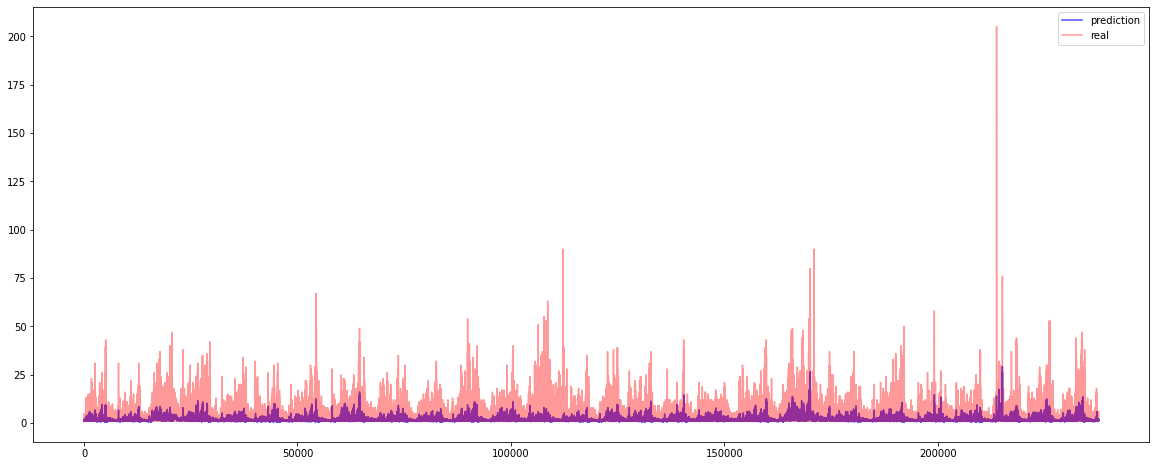

In [219]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,8))
plt.plot(X_test_pred,'b', alpha=0.7)
plt.plot(y_test.values,'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")

plt.show()

In [220]:
df_submission_sample.reset_index(drop=True,inplace=True)
df_submission_sample['QTT'] = X_submission_pred
df_submission_sample.head()

/tmp/ipykernel_3027/1936749470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission_sample['QTT'] = X_submission_pred


,DATE,S100,I100,C100,C101,QTT,item_id,I101,I102,I103,...,month,day,day_of_week,day_of_year,is_year_start,is_quarter_start,is_month_start,is_month_end,ID,QTT_reference
0,2021-10-03,0,1,12,140,1.340853,1_12_140,2,1,1,...,10,3,6,276,False,False,False,False,2021-10-03_0_1_12_140,1.373770
1,2021-10-03,0,1,12,164,1.279838,1_12_164,2,1,1,...,10,3,6,276,False,False,False,False,2021-10-03_0_1_12_164,1.451087
2,2021-10-03,0,1,12,339,1.298008,1_12_339,2,1,1,...,10,3,6,276,False,False,False,False,2021-10-03_0_1_12_339,1.311537
3,2021-10-03,0,1,13,128,1.263037,1_13_128,2,1,1,...,10,3,6,276,False,False,False,False,2021-10-03_0_1_13_128,1.282604
4,2021-10-03,0,1,14,164,1.362378,1_14_164,2,1,1,...,10,3,6,276,False,False,False,False,2021-10-03_0_1_14_164,1.673136


In [227]:
filename_submission= 'submission_baseline01_'+str(np.round(df_val_rmse,4))+'_'+str(np.round(df_test_rmse,4))+'_local.csv'
save = True
if save:
    print('saving..')
    print(filename_submission)
    df_submission_sample[['ID','QTT']].to_csv(os.path.join(PATH_RESULTS,'submissions',filename_submission),index=None)

saving..
submission_baseline01_2.2027_2.8456_local.csv


In [222]:
df_submission_sample[['ID','QTT']]

,ID,QTT
0,2021-10-03_0_1_12_140,1.340853
1,2021-10-03_0_1_12_164,1.279838
2,2021-10-03_0_1_12_339,1.298008
3,2021-10-03_0_1_13_128,1.263037
4,2021-10-03_0_1_14_164,1.362378
...,...,...
69116,2021-10-24_22_18_13_76,3.147484
69117,2021-11-07_22_18_12_76,2.132922
69118,2021-11-07_22_18_13_76,3.331959
69119,2021-10-17_22_12_15_79,2.099209


In [223]:
result = pd.read_csv(os.path.join(PATH_RESULTS,'submissions','submission_2.1046_local.csv'))

In [224]:
df_submission_sample['QTT_reference']= result['QTT'].copy()
df_submission_sample[['QTT_reference','QTT']][-20:]

/tmp/ipykernel_3027/848815569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_submission_sample['QTT_reference']= result['QTT'].copy()


,QTT_reference,QTT
69101,3.906683,5.018049
69102,3.740769,5.893526
69103,0.067038,2.076998
69104,2.382908,2.213521
69105,59.378511,28.656136
69106,65.152742,31.452772
69107,80.167873,33.093957
69108,89.173996,32.742018
69109,89.656533,33.059403
69110,72.946618,34.764282


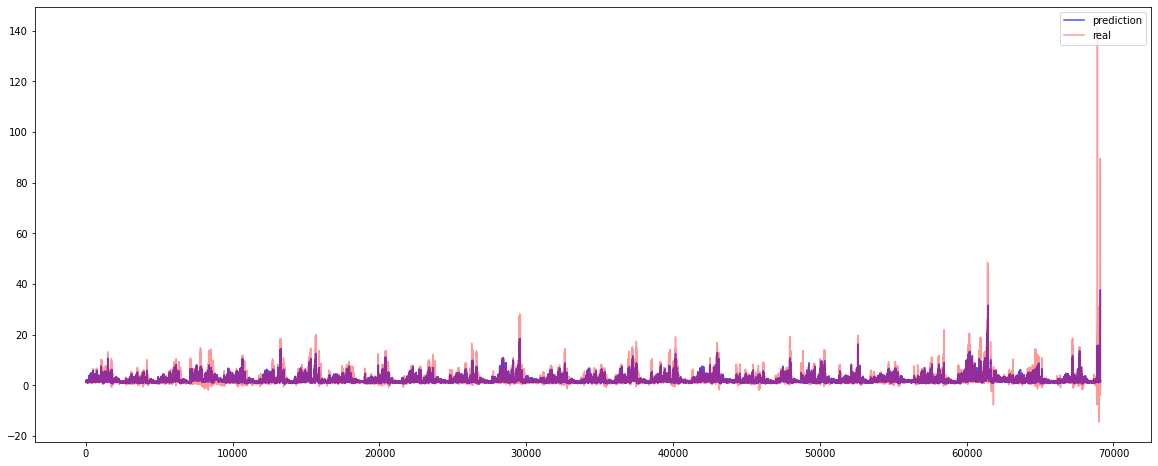

In [225]:
fig = plt.figure(figsize=(20,8))
plt.plot(df_submission_sample['QTT'],'b', alpha=0.7)
plt.plot(result['QTT'],'r', alpha=0.4)
plt.legend(["prediction", "real"], loc ="upper right")
plt.show()

In [226]:
difference = mean_squared_error(df_submission_sample['QTT'],result['QTT'], squared=False)

print('Final score mean_squared_error')
print('Score train:',difference)

Final score mean_squared_error
Score train: 1.2461280973337043
